This file will be used to train the policies and use them to generate the trajectories. 

Let's start by creating the environment we will be using: Cartpool

In [161]:
%load_ext autoreload
%autoreload 2
%aimport -numpy
%aimport -torch
%aimport -gym

import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
torch.manual_seed(0)

# for saving/loading
import os

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [163]:
env = gym.make('CartPole-v0')
env.seed(0)


[0]

For the definition of classes and functions for training the policies, refer to train_policy_func.py file 

In [164]:
## Define the policy network

from Train_policy_func import Policy, device
from Generate_traj_func import generate_trajectory

policy = Policy(state_size=env.observation_space.shape[0], action_size=env.action_space.n).to(device)

# Generate one trajectory for testing: 
traj = generate_trajectory(policy, env)
print(f"Episode length: {len(traj)}, Total reward: {sum(s['reward'] for s in traj)}")

Episode length: 17, Total reward: 17.0


In [165]:
# Training loop for PPO 41.8

from PPO import ppo_update, RolloutBuffer

# "In practice you’ll often tune these three carefully":
# clip_eps in [0.1, 0.3]
# lam in [0.90, 0.98]
# lr in [1e-5, 1e-3]"

# Hyperparameters
env_name     = "CartPole-v0"
updates      = 500        # how many times to run rollout+update, thus how many updates on the policy
actor_length = 4          # number of actors to run (in parallel if possible) per update
traj_length  = 200        # per actor
c1           = 0.5        # value loss coefficient
c2           = 0.01       # entropy coefficient, if not decaying. If so, check below
clip_eps     = 0.2        # PPO clipping parameter
gamma, lam   = 0.99, 0.95 # GAE parameters
lr           = 0.003
batch_size   = 64
epochs       = 4

# decaying entropy coefficient
entropy_coef_start = 0.01
entropy_coef_end   = 1e-4      # 0 or a small floor like 1e-4
max_updates = updates 

# Instantiate
env       = gym.make(env_name)
policy    = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=lr)
PPO_reward_per_update = []
buffer = RolloutBuffer()

for update in tqdm(range(updates)):
    buffer.clear() # clear the buffer for the next batch of trajectories
    avg_returns = []
    actor_rewards     = []

    # 1) Collect trajectories
    for N in range(actor_length):
        state = env.reset(seed=N) # seed for reproducibility
        steps = 0

        # for tracking episode returns within this batch
        current_ep_reward   = 0.0
        reward_per_actor = []
        
        # 1.1 one trajectory per actor
        while steps < traj_length:
            action, logp, value = policy.act(state)
            next_state, reward, done, _ = env.step(action)
            buffer.store(state, action, logp, reward, value, done)
            state = next_state
            steps += 1


            # accumulate for this episode
            current_ep_reward += reward

            if done:
                actor_rewards.append(current_ep_reward)
                current_ep_reward = 0.0
                state = env.reset(seed=2*N + steps) # reset for the next episode
                # break

        # in case the last episode didn’t terminate exactly on traj_length
        if current_ep_reward > 0.0:
            actor_rewards.append(current_ep_reward)

        # compute average return for this batch
        avg_ret = np.mean(actor_rewards)
        avg_returns.append(avg_ret)

    PPO_reward_per_update.append(np.mean(actor_rewards))

    # # 2) Compute last value (for GAE)     -> done in ppo_update ?
    # _, last_value = policy(torch.from_numpy(state).float().unsqueeze(0).to(device))

    # # 2.5) Linear-decay schedule:
    # frac = 1.0 - (update - 1) / float(max_updates)
    # c2 = entropy_coef_end + frac * (entropy_coef_start - entropy_coef_end)

    # # Or exponential:
    # c2 = entropy_coef_start * math.exp(-decay_rate * (update - 1))

    # 3) PPO update
    ppo_update(policy, optimizer, buffer,gamma,lam,c1, c2, clip_eps, epochs, batch_size)

    # 4) Saving checkpoint of the policy to get pi2
    if (update ) % 200 == 0 and update < updates/2:
        print(f"Update {update}/{updates} completed. Average return: {np.mean(actor_rewards)}")
        # save the policy
        torch.save(policy.state_dict(), f"pi2_checkpoint_{update}.pth")

# 5) at the end, save pi1
torch.save(policy.state_dict(), "pi1_final.pth")
print("Saved final policy as pi1_final.pth")



  0%|          | 1/500 [00:00<03:53,  2.14it/s]

Update 0/500 completed. Average return: 20.0


 40%|████      | 201/500 [01:52<02:43,  1.83it/s]

Update 200/500 completed. Average return: 36.36363636363637


100%|██████████| 500/500 [04:38<00:00,  1.80it/s]

Saved final policy as pi1_final.pth


In [166]:
## Generate preference pairs

# Load π₂ (weak) and π₁ (strong)
from pairs_generator import sample_preference_pairs

pi2 = Policy().to(device)
pi2.load_state_dict(torch.load("pi2_checkpoint_200.pth"))
pi2.eval()

pi1 = Policy().to(device)
pi1.load_state_dict(torch.load("pi1_final.pth"))
pi1.eval()

# Generate one trajectory each to inspect
traj1 = generate_trajectory(pi1, env, max_steps=1000)
traj2 = generate_trajectory(pi2, env, max_steps=1000)

print(f"π₂ → length {len(traj2)}, total reward {sum(s['reward'] for s in traj2):.1f}")
print(f"π₁ → length {len(traj1)}, total reward {sum(s['reward'] for s in traj1):.1f}")

prefs = sample_preference_pairs(pi1, pi2, env, K=200) # Need to define K elsewhere as hyperparameter
print(f"Collected {len(prefs)} preference pairs.")


C:\Users\turin\AppData\Local\Temp\ipykernel_147144\2183349200.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi2.load_state_dict(torch.load("pi2_checkpoint_200.pth"))
C

π₂ → length 70, total reward 70.0
π₁ → length 47, total reward 47.0
Collected 200 preference pairs.


In [167]:
## Visulization of the policies and trajectories
# %autoreload 2
from Generate_traj_func import plot_suboptimality, plot_trajectory_performance
from PPO import evaluate_policy

num_episodes = 100
pi1_mean_reward, pi1_reward = evaluate_policy(pi1, env, n_episodes=num_episodes)
pi2_mean_reward, pi2_reward = evaluate_policy(pi2, env, n_episodes=num_episodes)


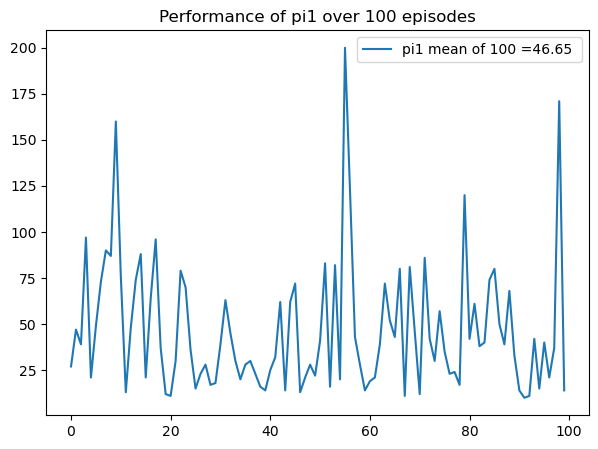

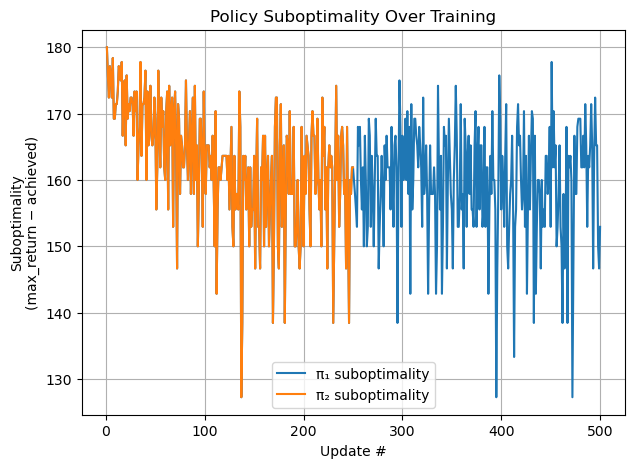

 size traj1: 47, size traj2: 70


In [168]:
plt.figure(figsize=(7, 5)) 
plt.plot(np.arange(len(pi1_reward)), pi1_reward, label=f"pi1 mean of 100 ={pi1_mean_reward} ")
plt.title("Performance of pi1 over 100 episodes" )
plt.legend()

plot_suboptimality(
    PPO_reward_per_update,
    PPO_reward_per_update[0 : int(len(PPO_reward_per_update) / 2)],
    200,
)  # in cartpole, 200 is the maximum reward
# plot_trajectory_performance(traj1, traj2)
print(f" size traj1: {len(traj1)}, size traj2: {len(traj2)}")

In [169]:
# # Training loop for OPPO
# from OPPO import baseline_1, OPPO_update
# from Train_policy_func import Policy, device

# lr_oppo = 0.01

# # ── Re-instantiate a fresh policy & optimizer for OPPO ──
# env_oppo   = gym.make(env_name)
# policy_oppo = Policy(state_size=env_oppo.observation_space.shape[0],
#                      action_size=env_oppo.action_space.n).to(device)
# opt_oppo    = torch.optim.Adam(policy_oppo.parameters(), lr=lr_oppo)

# # ── Hyperparams for OPPO ──
# n_episodes = 1200      # keep same “number of iterations” for fair comparison
# max_t      = 200  # cap on steps per episode
# print_every=100

# # ── Run the OPPO training ──
# scores_oppo = OPPO_update(
#     policy       = policy_oppo,
#     optimizer    = opt_oppo,
#     env          = env_oppo,
#     baseline     = baseline_1,
#     n_episodes   = n_episodes,
#     max_t        = max_t,
#     gamma        = gamma,      # you can reuse your PPO γ
#     print_every  = print_every,
#     early_stop   = False
# )

# # ── Post-processing: smooth or average returns per “block” if you like
# avg_scores_oppo = [
#     np.mean(scores_oppo[i : i + print_every])
#     for i in range(0, len(scores_oppo), print_every)
# ]




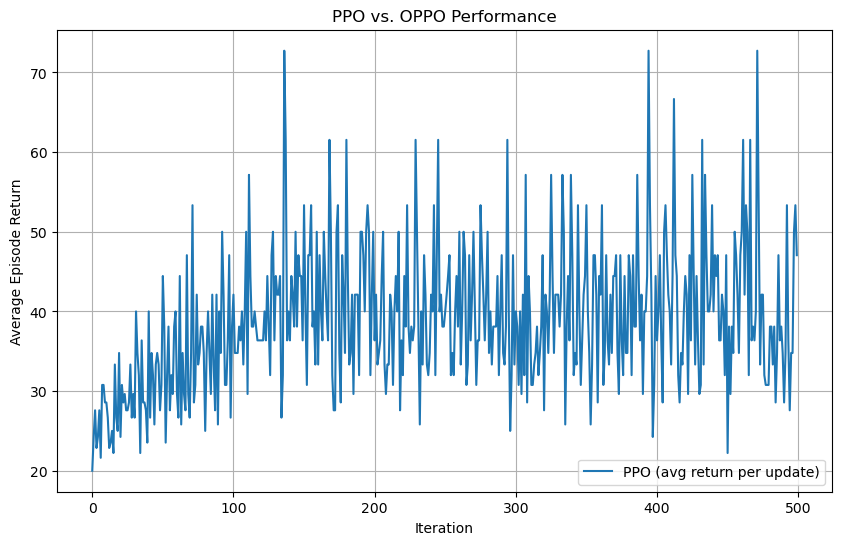

In [170]:

plt.figure(figsize=(10, 6)) 
plt.plot(
    np.arange(len(PPO_reward_per_update)), PPO_reward_per_update,
    label="PPO (avg return per update)"
)
# plt.plot(
#     100*np.arange(len(avg_scores_oppo)), avg_scores_oppo,
#     label=f"OPPO (avg return per {print_every} eps)"
# )
# plt.plot(
#     np.arange(len(scores_oppo)), scores_oppo,
#     label=f"OPPO (score)"
# )

plt.xlabel("Iteration")
plt.ylabel("Average Episode Return")
plt.legend()
plt.grid(True)
plt.title("PPO vs. OPPO Performance")
plt.show()